# Adversarial　Example -自作モデル編-
AE(Adversarial Example)は機械学習のモデルに対する攻撃の一つ。これを行うことで、モデルの予測を誤らせることができる。なお、この攻撃はモデルが明らかになっている場合に行うことができる。

具体的な手法としては、損失関数を最大化させる方向に"入力データ"を調整する。

まずはライブラリのインポート

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

ディレクトリの作成。事前に学習したモデルを取り込む。
``` bash
wget 'https://drive.google.com/uc?export=download&id=1KVOHbHnjCd1L-ookcd7CxDqb7rb8-DSx' -O './data/lenet_mnist_model.pth'
```

次に、画像に与える摂動の大きさεを定義する。このεは、0のときは元の画像のまま。大きいほどノイズが大きくなる。

In [2]:
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

# MNISTモデルの定義
.pthファイルはモデルの重みを与えている。そのため、モデルの構造を定義する必要がある。

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return F.log_softmax(x, dim=1)

## データセットとデータローダーの定義

MNISTデータセットからデータローダーを作成する。
ここで、transforms.ToTensor()は勝手に0~1の範囲に変換してくれる。

In [4]:
mnist_data = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]), download=True)

# トレーニングデータとテストデータに分割
train_data, test_data = torch.utils.data.random_split(mnist_data, [50000, 10000])
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True)
    

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=1, shuffle=True)

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available())else "cpu")


model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model,map_location='cpu'))

model.eval()# 推論を有効に

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# 特定のラベルになるように仕向ける攻撃
モデルの損失関数Eに対して以下の最小化問題をときたい。
$$min_{\delta \lambda} E(w,x+\delta ,k_{adv})+\lambda |\delta |_1$$

そのために、とりあえずマスク画像を作るCAE(Convolutional AutoEncoder)を作成して見た。

In [5]:

class AE_attacker(nn.Module):
    def __init__(self):
        super(AE_attacker,self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1), # 14x14
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 4x4
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 8, kernel_size=3, stride=2, padding=1,output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1,output_padding=1), # 28x28
            nn.Sigmoid()
            
        )

    
    def forward(self,x):

        z = self.encoder(x)
        #print(z.size())
        y = self.decoder(z)
        return y



## 損失関数の定義
モデルの損失関数Eに対して以下の損失を最小化させたい。(再掲)
$$min_{\delta } E(w,x+\delta ,k_{adv})+\lambda |\delta |_1$$

In [6]:
class CustomLoss(nn.Module):
    def __init__(self,l1_weight):
        super(CustomLoss,self).__init__()
        self.l1_weight = l1_weight
    
    def forward(self,attacker,model,data,mask,target):
        target_vec = torch.zeros(10).to(device)
        target_vec[target] = 1.0
        target_vec = target_vec.view(1,10)
        target_vec = torch.zeros(data.size()[0], 10).to(device)
        target_vec[:, target] = 1.0
        #print(data.size())
        #print(mask.size())
        outputs = model(data+mask)


       
        mnist_loss = F.mse_loss(outputs,target_vec)
        

        l1_loss = self.l1_weight*torch.mean(torch.abs(mask))

        return mnist_loss + l1_loss
    
    

In [8]:
import datetime
save_path = './model_weights'

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
attacker = AE_attacker()
attacker = attacker.to(device)
TARGET = 1
l1_weight = 1.0
loss_fn = CustomLoss(l1_weight)

learning_rate = 0.001
optimizer = optim.Adam(attacker.parameters(),lr=learning_rate)

num_epochs = 40
for epoch in range(num_epochs):
    for data,_ in train_loader:
        
        # 入力データの取得
        data = data.to(device)
       

        # マスクの生成
        mask = attacker(data)

        # 損失の計算と逆伝播
        loss = loss_fn(attacker,model,data,mask, TARGET)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # エポックごとに損失を表示
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
state_dict = attacker.state_dict()
now = datetime.datetime.now()
filename = f"model_weights_{now:%Y-%m-%d_%H-%M-%S}.pth"
save_path = os.path.join(save_path,filename)
torch.save(state_dict, save_path)


Epoch [1/40], Loss: 6.1283
Epoch [2/40], Loss: 6.0602
Epoch [3/40], Loss: 5.9974
Epoch [4/40], Loss: 6.0083
Epoch [5/40], Loss: 5.9927
Epoch [6/40], Loss: 5.9959
Epoch [7/40], Loss: 5.9748
Epoch [8/40], Loss: 5.9865
Epoch [9/40], Loss: 5.9817
Epoch [10/40], Loss: 5.9687
Epoch [11/40], Loss: 5.9760
Epoch [12/40], Loss: 5.9940
Epoch [13/40], Loss: 5.9748
Epoch [14/40], Loss: 5.9764
Epoch [15/40], Loss: 5.9658
Epoch [16/40], Loss: 5.9651
Epoch [17/40], Loss: 5.9631
Epoch [18/40], Loss: 5.9649
Epoch [19/40], Loss: 5.9714
Epoch [20/40], Loss: 5.9627
Epoch [21/40], Loss: 5.9623
Epoch [22/40], Loss: 5.9702
Epoch [23/40], Loss: 5.9506
Epoch [24/40], Loss: 5.9674
Epoch [25/40], Loss: 5.9740
Epoch [26/40], Loss: 5.9681
Epoch [27/40], Loss: 5.9576
Epoch [28/40], Loss: 5.9561
Epoch [29/40], Loss: 5.9681
Epoch [30/40], Loss: 5.9519
Epoch [31/40], Loss: 5.9602
Epoch [32/40], Loss: 5.9741
Epoch [33/40], Loss: 5.9617
Epoch [34/40], Loss: 5.9650
Epoch [35/40], Loss: 5.9642
Epoch [36/40], Loss: 5.9635
E

In [9]:
def test(model,attacker,device,test_loader):
    attacker.eval()
    # 精度を計算 
    success = 0
    adv_examples = []
    for data,target in test_loader:
        data = data.to(device)
        target = target.to(device)
        data.requires_grad = True

        output = model(data)# 攻撃対象モデルの出力(尤度)
        MNIST_predict = output.max(1,keepdim=True)[1].item() # 攻撃対象の予測結果

        print(MNIST_predict)
        #print(target.item())
        if MNIST_predict != target.item():
            continue
        attacked_data = data + attacker(data)

        output = model(attacked_data)# MNISTの出力

        MNIST_predict_after_attack = output.max(1,keepdim=True)[1].item() # MNISTの予測結果
        #print(MNIST_predict,MNIST_predict_after_attack)
        if MNIST_predict_after_attack == TARGET:
            success +=1
            
            if len(adv_examples) < 5:
                adv_ex = attacked_data.squeeze().detach().cpu().numpy()
                adv_examples.append((data,attacked_data.item(),adv_ex))
    attack_success_rate = success/float(len(test_loader))

    print("Attack Success Rate = {} / {} = {}".format(success,len(test_loader),attack_success_rate))
    return attack_success_rate,adv_examples



        

        

In [10]:
def test(model,attacker,device,test_loader):
    attacker.eval()
    # 精度を計算 
    success = 0
    MNIST_predicts = []
    MNIST_predicts_after_attack = []
    before_attacks = np.array([])
    after_attacks = np.array([])
    for data,target in test_loader:
        data = data.to(device)
        target = target.to(device)
        data.requires_grad = True

        output = model(data)# 攻撃対象モデルの出力
        MNIST_predict = output.max(1,keepdim=True)[1]# 攻撃対象モデルの予測結果

        #print(MNIST_predict)
        #print(target.item())
        if MNIST_predict.item() != target.item():
            continue
        attacked_data = data + attacker(data)

        output = model(attacked_data)# MNISTの出力

        MNIST_predict_after_attack = output.max(1,keepdim=True)[1] # MNISTの予測結果
        #print(MNIST_predict,MNIST_predict_after_attack)
        if MNIST_predict_after_attack.item() == TARGET:#ここ怪しい
            success +=1
            
            if len(MNIST_predicts) < 5:

                before_pic = data.squeeze().detach().cpu().numpy()
                before_pic = np.array(before_pic,dtype=np.float32)
                adv_ex = attacked_data.squeeze().detach().cpu().numpy()
                adv_ex = np.array(adv_ex,dtype=np.float32)
                #adv_examples.append((MNIST_predict.item(),MNIST_predict_after_attack.item(),before_pic,adv_ex))
                MNIST_predicts.append(MNIST_predict.item())
                MNIST_predicts_after_attack.append(MNIST_predict_after_attack.item())
                before_attacks = np.append(before_attacks,before_pic)
                after_attacks = np.append(after_attacks,adv_ex)
                

    attack_success_rate = success/float(len(test_loader))

    print("Attack Success Rate = {} / {} = {}".format(success,len(test_loader),attack_success_rate))
    before_attacks = before_attacks.reshape(-1,28,28)
    after_attacks = after_attacks.reshape(-1,28,28)
    return attack_success_rate,MNIST_predicts,MNIST_predicts_after_attack,before_attacks,after_attacks

In [12]:

attacker = AE_attacker()
attacker = attacker.to(device)
weights_path = "./model_weights/model_weights_2023-05-06_20-43-44.pth"
accuracies = []
examples = []

attacker.load_state_dict(torch.load(weights_path,map_location='cpu'))

acc,MNIST_predicts,MNIST_predicts_after_attack,before_attacks,after_attacks= test(model,attacker,device,test_loader)



Attack Success Rate = 7420 / 10000 = 0.742


モデルの予測結果: 6 -> 攻撃後の予測結果: 1


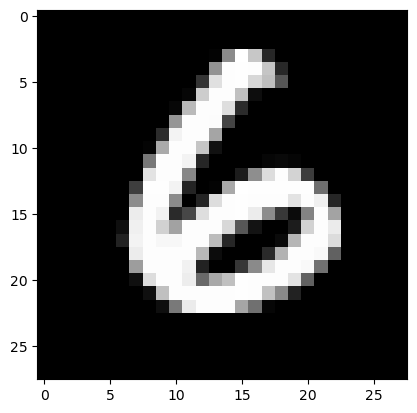

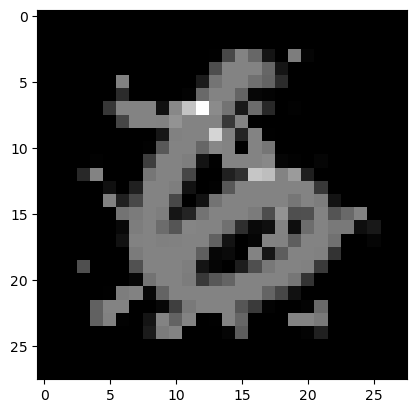

モデルの予測結果: 0 -> 攻撃後の予測結果: 1


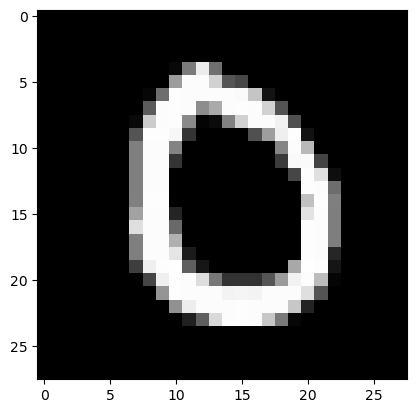

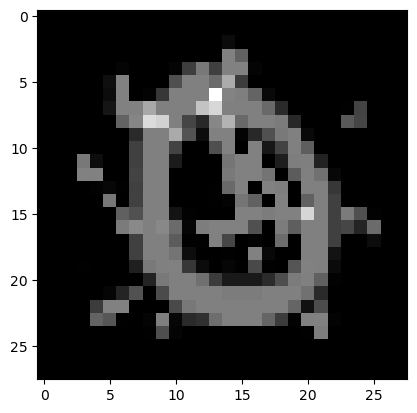

モデルの予測結果: 9 -> 攻撃後の予測結果: 1


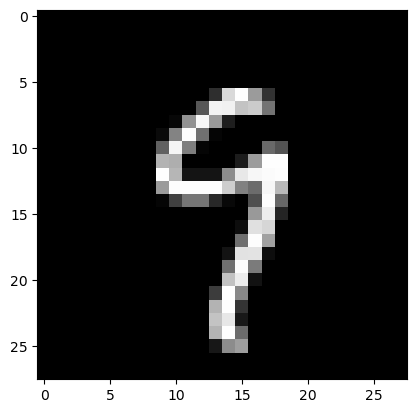

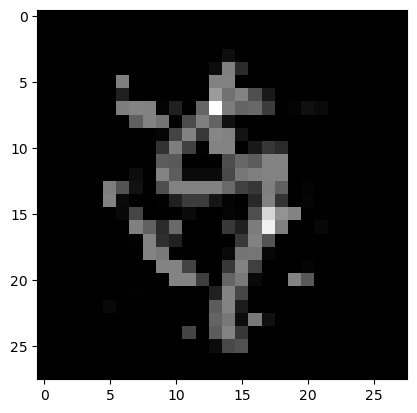

In [13]:


for j in range(3):


# 画像として表示する
    print("モデルの予測結果: {} -> 攻撃後の予測結果: {}".format(MNIST_predicts[j],MNIST_predicts_after_attack[j]))
    plt.imshow(before_attacks[j], cmap="gray")
    plt.show()
    plt.imshow(after_attacks[j], cmap="gray")
    plt.show()
